In [2]:
!pip install -q sentence-transformers
!pip install -q pdfplumber
!pip install -q faiss-cpu
!pip install -q matplotlib
!pip install -q numpy
!pip install requests
!pip install -q beautifulsoup4
!pip install -q rapidfuzz
!pip install -q networkx
!pip install -q scikit-learn
!pip install -q python-dotenv
!pip install tqdm
!pip install -q pypdf
!pip install -q google-genai
!pip install -q langgraph
!pip install -q langchain-anthropic
!pip install langchain-core

In [34]:
from sentence_transformers import SentenceTransformer
import pdfplumber
import os
import faiss
import matplotlib.pyplot as plt
import numpy as np
import re
from pprint import pprint

import requests
from bs4 import BeautifulSoup
from rapidfuzz import process, fuzz

import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel

from dotenv import load_dotenv

from tqdm.notebook import trange, tqdm
from collections import Counter

import xml.etree.ElementTree as ET
import re
from tqdm import tqdm
from IPython.display import display, Markdown


import os
from typing import List, TypedDict, Optional

import google.genai as genai
from langgraph.graph import StateGraph, END
from langchain_anthropic import ChatAnthropic
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from pypdf import PdfReader

import json

from dotenv import load_dotenv
# api key
load_dotenv()
os.environ["ANTHROPIC_API_KEY"] = os.getenv("CLAUDE_API_KEY") 


In [4]:
class AgentState(TypedDict):
    input: str
    is_legal: bool
    codes: List[str]
    results: dict

llm = ChatAnthropic(
    model="claude-sonnet-4-5-20250929",
    temperature=0
)


### Juridique?

In [5]:
legal_prompt = ChatPromptTemplate.from_messages([
    ("system",
     "Tu es juriste expert en droit français.\n"
     "est ce que le texte suivant relève du droit français ?\n"
     "Réponds STRICTEMENT par OUI ou NON."),
    ("human", "{text}")
])

legal_chain = legal_prompt | llm | StrOutputParser()

def is_french_law(state: AgentState):
    resp = legal_chain.invoke({"text": state["input"]}).strip().upper()
    return {**state, "is_legal": resp == "OUI"}


### Code?

In [6]:
code_prompt = ChatPromptTemplate.from_messages([
    ("system",
     "Retourne STRICTEMENT du JSON valide.\n"
     "tu dois extraire les noms des codes juridiques français qui pourrais etre utile dans le texte donné.\n"
     "Exemples :\n"
     '["CodeCivil"]\n'
     '["CodedelaRoute"]'
     '["CodeCivil", "CodePenal"]\n'
     '[]\n'
     "AUCUN texte autour."),
    ("human", "{text}")
])



code_chain = code_prompt | llm | StrOutputParser()



def detect_codes(state: AgentState):
    raw = code_chain.invoke({"text": state["input"]})
    try:
        json_text = raw[raw.find("["):raw.rfind("]")+1]
        codes = json.loads(json_text)
    except json.JSONDecodeError:
        codes = []
    return {**state, "codes": codes, "results": {}}


## Recherche locale

In [7]:
def check_local_files(state: AgentState):
    results = {}

    for code in state["codes"]:
        base = f"./code/{code}"

        if os.path.exists(base + ".xml"):
            results[code] = {
                    "type": "xml",
                    "source": "local",
                    "url": base + ".xml"
                }

        elif os.path.exists(base + ".pdf"):
            results[code] = {
                    "type": "pdf",
                    "source": "local",
                    "url": base + ".pdf"
                }
        else:
            results[code] = None

    return {**state, "results": results}


## Recherche online

In [8]:
# Fonction pour normaliser la recherche


def get_all_codes():
    url = "https://codes.droit.org/"
    response = requests.get(url)
    html_content = response.text

    # Parsing du HTML avec BeautifulSoup
    soup = BeautifulSoup(html_content, "html.parser")

    # Trouver tous les liens <a> dont href se termine par .xml
    xml_links = [a['href'] for a in soup.find_all('a', href=True) if a['href'].endswith('.xml')]

    return [link.replace("payloads/", "").replace(".xml", "") for link in xml_links]


def find_best_code(user_input, threshold=70):
    codes = get_all_codes()

    if not codes:
        return None

    meilleur_match = process.extractOne(user_input, codes, scorer=fuzz.ratio)

    return "https://codes.droit.org/payloads/" + meilleur_match[0] +".xml"

def fetch_online_xml(state: AgentState):
    for code, result in state["results"].items():
        if result is None:
            url = find_best_code(code)
            r = requests.get(url)
            if r.status_code == 200:
                state["results"][code] = {
                    "type": "xml",
                    "source": "online",
                    "url": url
                }
    return state


## CONSTRUCTION DU GRAPHE 

In [9]:
def route_legal(state: AgentState):
    return "detect" if state["is_legal"] else END

graph = StateGraph(AgentState)

graph.add_node("is_legal", is_french_law)
graph.add_node("detect", detect_codes)
graph.add_node("local", check_local_files)
graph.add_node("online", fetch_online_xml)

graph.set_entry_point("is_legal")

graph.add_conditional_edges(
    "is_legal",
    route_legal,
    {"detect": "detect", END: END}
)

graph.add_edge("detect", "local")
graph.add_edge("local", "online")
graph.add_edge("online", END)

app = graph.compile()


In [10]:

query = "j'ai des questions sur le code de la route et le code civil"
result = app.invoke({
    "input": query
})


pprint(result)


{'codes': ['CodedelaRoute', 'CodeCivil'],
 'input': "j'ai des questions sur le code de la route et le code civil",
 'is_legal': True,
 'results': {'CodeCivil': {'source': 'local',
                           'type': 'pdf',
                           'url': './code/CodeCivil.pdf'},
             'CodedelaRoute': {'source': 'online',
                               'type': 'xml',
                               'url': 'https://codes.droit.org/payloads/Code%20de%20la%20route.xml'}}}


# PDF

In [11]:
def extract_text_from_pdfs(file_path):
    filename = os.path.basename(file_path)
    path = os.path.join(file_path)
    text = ""
    with pdfplumber.open(path) as pdf:
        for page in pdf.pages:
            text += page.extract_text() + "\n"
    return (filename, text)

def extract_articles_from_pdf(code):
    text= code[1]
    parts = re.split(r'(Article\s\d+[^\n]*)', text)
    articles = []
    for i in range(1, len(parts), 2):
        title = parts[i].strip()
        content = parts[i + 1].strip()
        articles.append({"code":code[0],"title": title, "content": content,"structure" : None})
    return articles


# papers = extract_text_from_pdfs("./code/CodeCivil.pdf")

# articles = extract_articles(papers)
# for article in articles:
#     all_articles.append({"filename": papers[0], "title": article["title"], "content": article["content"]})

# print(articles[:5])

# Web and Xml

In [12]:
def load_code_xml(url):
    response = requests.get(url)
    response.raise_for_status()
    return ET.fromstring(response.content)

def load_local_code_xml(file_path):
    tree = ET.parse(file_path)
    return tree.getroot()

def extract_articles_from_xml(root):
    articles = []
    # take the first line it's the title

    # Structure hiérarchique actuelle
    current_structure = {
        0: None,  # Partie législative
        1: None,  # Livre
        2: None,  # Titre
        3: None   # Chapitre
    }

    for elem in root.iter():
        tag = elem.tag.lower()
        if tag== "code":
            code= elem.attrib.get("nom")
        if tag == "t":
            niveau = int(elem.attrib.get("niveau", -1))
            title = elem.attrib.get("title")
            if niveau >= 0:
                current_structure[niveau] = title
                for lvl in range(niveau + 1, 4):
                    current_structure[lvl] = None

        # Gestion des articles
        elif tag == "article":
            num = elem.attrib.get("num")
            article_id = elem.attrib.get("id") or elem.attrib.get("num")
            # Récupère le texte complet, en incluant <br/> comme retour à la ligne
            texte = "".join(elem.itertext()).replace("\n", " ").replace("<br/>", "\n").strip()

            if not article_id or not texte:
                continue

            articles.append({
                "code": code,
                "title": f"Article {num}",
                "content": texte,
                "structure": [
                    current_structure[0],
                    current_structure[1],
                    current_structure[2],
                    current_structure[3]
                ]
            })

    return articles


# root=load_code_xml("https://codes.droit.org/payloads/Code%20p%C3%A9nal.xml")
# new_articles = extract_articles_from_xml(root)

In [13]:
all_articles = []
for i in result["results"]:
    print(result["results"][i]["source"])
    if result["results"][i]["source"] == "online":
        root=load_code_xml(result["results"][i]["url"])
        articles = extract_articles_from_xml(root)
        all_articles.extend(articles)
    if result["results"][i]["source"] == "local":
        if result["results"][i]["type"] == "xml":
            root=load_local_code_xml(result["results"][i]["url"])
            articles = extract_articles_from_xml(root)
            all_articles.extend(articles)
        elif result["results"][i]["type"] == "pdf":
            root=extract_text_from_pdfs(result["results"][i]["url"])
            articles = extract_articles_from_pdf(root)
            all_articles.extend(articles)

online
local


In [14]:
print(len(all_articles))

4053


In [24]:
import torch
import gc
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
import networkx as nx

# Configuration pour optimiser l'utilisation de la mémoire GPU
torch.cuda.empty_cache()
gc.collect()

# Charger le modèle avec optimisations mémoire
embedder = SentenceTransformer(
    'dangvantuan/french-document-embedding',
    trust_remote_code=True,
    device='cuda'  # ou 'cpu' si nécessaire
)

# Réduire la précision pour économiser de la mémoire (optionnel mais efficace)
embedder.half()  # Utilise float16 au lieu de float32

def embed_articles(all_articles, batch_size=8):
    """
    Embedding par batch pour éviter les problèmes de mémoire
    batch_size réduit à 8 (au lieu de 16 par défaut)
    """
    texts = [a['content'] for a in all_articles]
    
    # Embeddings par batch avec nettoyage mémoire
    embeddings = embedder.encode(
        texts,
        batch_size=batch_size,
        show_progress_bar=True,
        convert_to_numpy=True,
        normalize_embeddings=False
    )
    
    # Nettoyer la mémoire GPU après encoding
    torch.cuda.empty_cache()
    gc.collect()
    
    return embeddings

def build_faiss_index(embeddings):
    """
    Construction de l'index FAISS
    """
    if embeddings.dtype != np.float32:
        embeddings = embeddings.astype(np.float32)
    
    dim = embeddings.shape[1]  # Utiliser shape[1] plutôt que [0]
    index = faiss.IndexFlatL2(dim)
    index.add(embeddings)
    
    return index

def build_graph(all_articles):
    """
    Construction du graphe
    """
    G = nx.DiGraph()
    for article in all_articles:
        node_id = f"{article['code']} {article['title']}"
        G.add_node(node_id, content=article['content'])
    return G

# Fonction pour libérer complètement la mémoire GPU si besoin
def clear_gpu_memory():
    """
    Nettoie complètement la mémoire GPU
    """
    torch.cuda.empty_cache()
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.synchronize()


In [16]:
embeddings = embed_articles(all_articles)
index = build_faiss_index(embeddings)
G = build_graph(all_articles)

Batches:   0%|          | 0/507 [00:00<?, ?it/s]

In [27]:
def enrich_with_cross_references(G, all_articles):
    # Préparer et compiler les patterns
    patterns = {
        a["title"]: re.compile(
            r"(?<![\w\d])" + re.escape(a["title"]) + r"(?![\w\d])", 
            re.IGNORECASE
        )
        for a in all_articles
    }

    articles_by_code = {}
    for a in all_articles:
        articles_by_code.setdefault(a["code"], []).append(a)

    # Parcours par code
    for code, articles in articles_by_code.items():
        for a in tqdm(articles, desc=f"Cross references for code {code}"):
            source = a["title"]
            content = a["content"]
            articles_node_source= f"{a['code']} {a['title']}"

            for target_article in articles:
                target = target_article["title"]
                articles_node_target= f"{target_article['code']} {target_article['title']}"
                if target == source:
                    continue
                if patterns[target].search(content):
                    G.add_edge(articles_node_source, articles_node_target, relation="cite")

def add_structure_nodes(G, all_articles):
    for art in all_articles:

        article_node = f"{art['code']} {art['title']}"

        # Securitey
        if not G.has_node(article_node):
            G.add_node(
                article_node,
                type="article",
                content=art["content"]
            )

        # CAS 1 — structure non fournie → extraction regex
        if art["structure"] is None:
            structure = re.findall(
                r"Livre [IVX]+|Titre [\w\s]+|Chapitre [\w\d]+",
                art["content"]
            )

            for s in structure:
                if not G.has_node(s):
                    G.add_node(s, type="structure")

                G.add_edge(s, article_node, relation="contient")

        # CAS 2 — structure déjà fournie
        else:
            for s in art["structure"]:
                if not s:
                    continue

                if not G.has_node(s):
                    G.add_node(s, type="structure")

                G.add_edge(s, article_node, relation="contient")


def enrich_with_semantic_similarity(G, all_articles, embeddings, threshold=0.82):
    sim_matrix = cosine_similarity(embeddings)
    for i in range(len(all_articles)):
        for j in range(i+1, len(all_articles)):
            if sim_matrix[i][j] >= threshold:
                G.add_edge(f"{all_articles[i]['code']} {all_articles[i]['title']}", f"{all_articles[j]['code']} {all_articles[j]['title']}", relation="similaire", weight=sim_matrix[i][j])

def add_articles_to_graph(G, all_articles):
    for art in all_articles:
        # article node
        if not G.has_node(art["title"]):
            G.add_node(
                art["title"],
                type="article",
                text=art["content"]
            )

        # structure nodes
        for s in art["structure"]:
            if not s:
                continue

            if not G.has_node(s):
                G.add_node(s, type="structure")

            G.add_edge(s, f"{art['code']} {art['title']}", relation="contient")

In [28]:
enrich_with_cross_references(G,all_articles)
add_structure_nodes(G,all_articles)
enrich_with_semantic_similarity(G,all_articles,embeddings)

def evaluate_graph_structure(G):

    stats = {
        "nodes": len(G.nodes),
        "edges": len(G.edges),
        "density": nx.density(G),
        "is_connected": nx.is_connected(G.to_undirected()),
        "components": nx.number_connected_components(G.to_undirected()),
        "relation_distribution": Counter(nx.get_edge_attributes(G, "relation").values())
    }
    return stats
evaluate_graph_structure(G)


Cross references for code CodeCivil.pdf: 100%|██████████| 2890/2890 [02:37<00:00, 18.32it/s]


{'nodes': 7840,
 'edges': 48520,
 'density': 0.0007894853310631562,
 'is_connected': False,
 'components': 579,
 'relation_distribution': Counter({'similaire': 37274,
          'contient': 9712,
          'cite': 1534})}

In [29]:
def get_subgraph_for_article(G, article_title, depth=1):
    visited = set([article_title])
    frontier = set([article_title])

    for _ in range(depth):
        next_frontier = set()
        for node in frontier:
            next_frontier.update(G.successors(node))     
            next_frontier.update(G.predecessors(node))    
        frontier = next_frontier - visited
        visited.update(frontier)

    subG = G.subgraph(visited).copy()
    return subG

def visualize_article_graph(G, article_title, depth=1):
    subG = get_subgraph_for_article(G, article_title, depth=depth)

    pos = nx.spring_layout(subG, seed=42)
    plt.figure(figsize=(10, 7))
    
    edge_labels = nx.get_edge_attributes(subG, 'relation')
    node_colors = ['red' if n == article_title else 'skyblue' for n in subG.nodes]
    
    nx.draw(subG, pos, with_labels=True, node_color=node_colors, node_size=1500, font_size=10, arrows=True)
    nx.draw_networkx_edge_labels(subG, pos, edge_labels=edge_labels, font_color='gray')

    plt.title(f"Graphe centré sur {article_title}")
    plt.show()


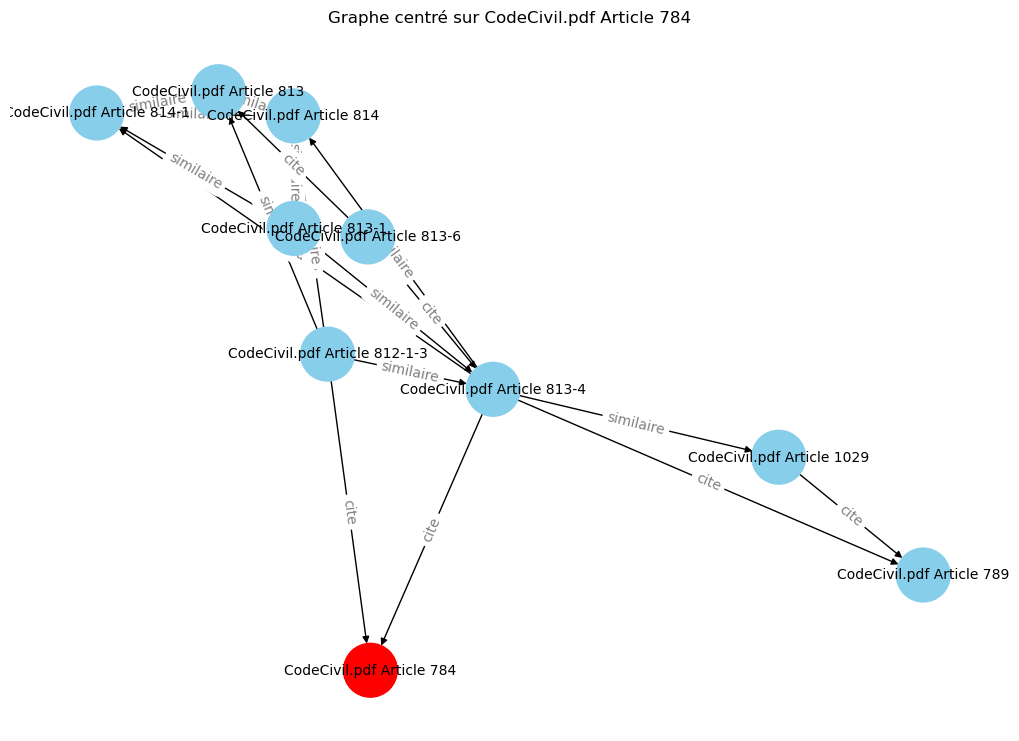

In [31]:
visualize_article_graph(G, "CodeCivil.pdf Article 784", depth=2)


In [35]:
client = genai.Client(api_key=os.getenv("GEMINI_API_KEY"))

def generate_answer(final_prompt: str) -> str:
    response = client.models.generate_content(
        model="gemini-2.5-flash-lite",
        contents=final_prompt
    )
    return response.text
    
def retrieve_similar(query, embedder, index, all_articles, k=5):
    query_vec = embedder.encode([query])
    D, I = index.search(np.array(query_vec), k)
    return [all_articles[i] for i in I[0]]

relevant_docs = retrieve_similar("Qu’est-ce qu’un contrat synallagmatique ?", embedder, index, all_articles)

def ask(question, retrieved_docs):
    context = "\n\n".join([f"{doc['title']}: {doc['content']}" for doc in retrieved_docs])
    prompt = f"Réponds à la question suivante selon les extraits de la loi francaise :\n\n{context}\n\nQuestion: {question}\nRéponse:"
    
    answer = generate_answer(prompt)

    display(Markdown(f"**Question:** {question}"))
    display(Markdown(f"**Réponse :**\n{answer}"))
    display(Markdown("**Sources:**"))
    for doc in retrieved_docs:
        display(Markdown(f"{doc['title']}: {doc['content']}"))
    return answer


response = ask("Qu’est-ce qu’un contrat synallagmatique ?", relevant_docs)


**Question:** Qu’est-ce qu’un contrat synallagmatique ?

**Réponse :**
Selon les extraits de la loi française :

Un contrat synallagmatique est un contrat dans lequel **les contractants s'obligent réciproquement les uns envers les autres**.

**Sources:**

Article 1106: Le contrat est synallagmatique lorsque les contractants s'obligent réciproquement les uns envers les autres.
Il est unilatéral lorsqu'une ou plusieurs personnes s'obligent envers une ou plusieurs autres sans qu'il y ait
d'engagement réciproque de celles-ci.

Article 1168: Dans les contrats synallagmatiques, le défaut d'équivalence des prestations n'est pas une cause de nullité du
contrat, à moins que la loi n'en dispose autrement.

Article 1375: L'acte sous signature privée qui constate un contrat synallagmatique ne fait preuve que s'il a été fait en
autant d'originaux qu'il y a de parties ayant un intérêt distinct, à moins que les parties ne soient convenues de
remettre à un tiers l'unique exemplaire dressé.
Chaque original doit mentionner le nombre des originaux qui en ont été faits.
Celui qui a exécuté le contrat, même partiellement, ne peut opposer le défaut de la pluralité d'originaux ou de
la mention de leur nombre.
L'exigence d'une pluralité d'originaux est réputée satisfaite pour les contrats sous forme électronique lorsque
l'acte est établi et conservé conformément aux articles 1366 et 1367, et que le procédé permet à chaque partie
de disposer d'un exemplaire sur support durable ou d'y avoir accès.

Article 1109: Le contrat est consensuel lorsqu'il se forme par le seul échange des consentements quel qu'en soit le mode
d'expression.
Le contrat est solennel lorsque sa validité est subordonnée à des formes déterminées par la loi.
Le contrat est réel lorsque sa formation est subordonnée à la remise d'une chose.

Article 1172: Les contrats sont par principe consensuels.
Par exception, la validité des contrats solennels est subordonnée à l'observation de formes déterminées par la
loi à défaut de laquelle le contrat est nul, sauf possible régularisation.
En outre, la loi subordonne la formation de certains contrats à la remise d'une chose.